This post demonstrates the use of the Self-Exciting Threshold Autoregression module I wrote for the [Statsmodels](https://github.com/statsmodels/statsmodels) Python package, to analyze the often-examined [Sunspots dataset](http://www.ngdc.noaa.gov/stp/solar/ssndata.html). In particular, I pick up where the Sunspots section of the Statsmodels [ARMA Notebook example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_arma.html) leaves off, and look at estimation and forecasting of SETAR models.

<!-- TEASER_END -->

<!-- TEASER_END -->



Note: here we consider the raw Sunspot series to match the ARMA example, although many sources in the literature apply a transformation to the series before modeling.

<!-- TEASER_END -->

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.setar_model as setar_model
import statsmodels.tsa.bds as bds

In [2]:
print sm.datasets.sunspots.NOTE


Number of Observations - 309 (Annual 1700 - 2008)
Number of Variables - 1
Variable name definitions::

    SUNACTIVITY - Number of sunspots for each year

The data file contains a 'YEAR' variable that is not returned by load.



In [3]:
dta = sm.datasets.sunspots.load_pandas().data

In [4]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

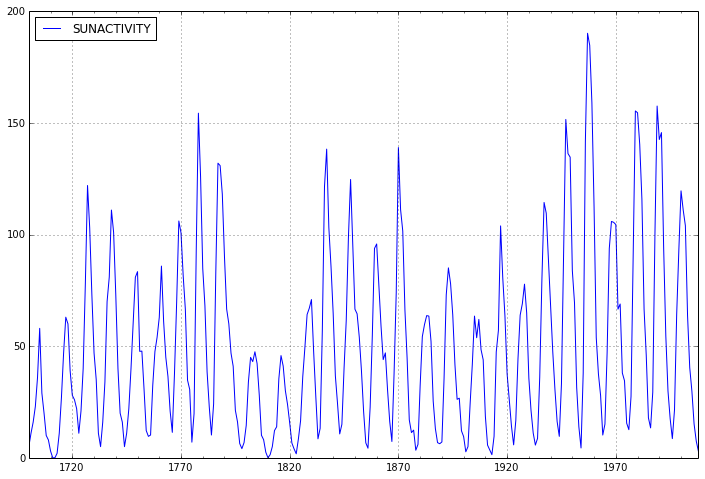

In [5]:
dta.plot(figsize=(12,8));

First we'll fit an AR(3) process to the data as in the ARMA Notebook Example.

In [6]:
arma_mod30 = sm.tsa.ARMA(dta, (3,0)).fit()
print arma_mod30.params
print arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic

const                49.749948
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129650
dtype: float64
2619.4036287 2638.07033508 2626.8666135


To test for non-linearity, we can use the BDS test on the residuals of the linear AR(3) model.

In [7]:
bds.bds(arma_mod30.resid, 3)

([[ 4.64937929  5.71214194]], [[  3.32935460e-06   1.11562974e-08]])

The null hypothesis of the BDS test is that the given series is an iid process (independent and identically distributed). Here the p-values are small enough that we can confidently reject the null (of iid).

This suggests there may be an underlying non-linear structure. To try and capture this, we'll fit a SETAR(2) model to the data to allow for two regimes, and we let each regime be an AR(3) process. Here we're not specifying the delay or threshold values, so they'll be optimally selected from the model.

Note: In the summary, the \gamma parameter(s) are the threshold value(s).

In [8]:
setar_mod23 = setar_model.SETAR(dta, 2, 3).fit()
print setar_mod23.summary()

                           SETAR Regression Results                           
Dep. Variable:            SUNACTIVITY   No. Observations:                  306
Model:                   SETAR(2;3,3)   Df Residuals:                      298
Method:                 Least Squares   Df Model:                            7
Date:                Sat, 10 Aug 2013   Log-Likelihood:                -1234.4
Time:                        14:50:20   AIC:                             2485.
Sample:                       4 - 309   BIC:                             2515.
                 coef  [95.0% Conf. Int.]
-----------------------------------------
Delay               3                    
\gamma_1       32.300    30.700    36.700
        Regime 1                                                                             
 y_{t-3} in (-Inf, 32.30]       coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------

Note that the The AIC and BIC criteria prefer the SETAR model to the AR model.

We can also directly test for the appropriate model, noting that an AR(3) is the same as a SETAR(1;1,3), so the specifications are nested.

Note: this is a bootstrapped test, so it is rather slow until improvements can be made.

In [9]:
setar_mod23 = setar_model.SETAR(dta, 2, 3).fit()
f_stat, pvalue, bs_f_stats = setar_mod23.order_test() # by default tests against SETAR(1)
print pvalue

0.0


The null hypothesis is a SETAR(1), so it looks like we can safely reject it in favor of the SETAR(2) alternative.

One thing to note, though, is that the default assumptions of `order_test()` is that there is homoskedasticity, which may be unreasonable here. So we can force the test to allow for heteroskedasticity of general form (in this case it doesn't look like it matters, however).

In [10]:
f_stat_h, pvalue_h, bs_f_stats_h = setar_mod23.order_test(heteroskedasticity='g')
print pvalue

0.0


Note that the BDS test still rejects the null when considering the residuals of the series, although with less strength than it did the AR(3) model. We can take a look at the residual plot to see that it appears the errors may have a mean of zero, but may not exhibit homoskedasticity (see Hansen (1999) for more details).

(array([[ 2.9728394 ,  3.02855581]]), array([[ 0.00295059,  0.00245726]]))


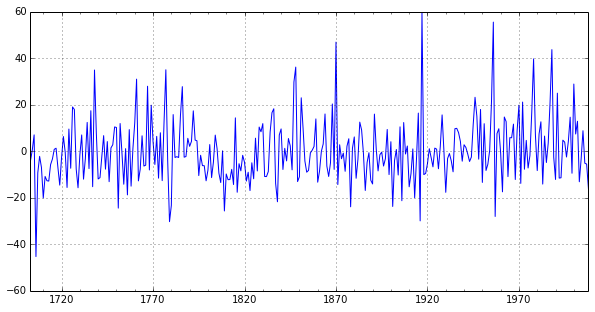

In [11]:
print bds.bds(setar_mod23.resid, 3)
setar_mod23.resid.plot(figsize=(10,5));

We have two new types of parameters estimated here compared to an ARMA model. The delay and the threshold(s). The delay parameter selects which lag of the process to use as the threshold variable, and the thresholds indicate which values of the threshold variable separate the datapoints into the (here two) regimes.

The confidence interval for the threshold parameter is generated (as in Hansen (1997)) by inverting the likelihood ratio statistic created from  considering the selected threshold value against ecah alternative threshold value, and comparing against critical values for various confidence interval levels. We can see that graphically by plotting the likelihood ratio sequence against each alternate threshold.

Alternate thresholds that correspond to likelihood ratio statistics less than the critical value are included in a confidence set, and the lower and upper bounds of the confidence interval are the smallest and largest threshold, respectively, in the confidence set.

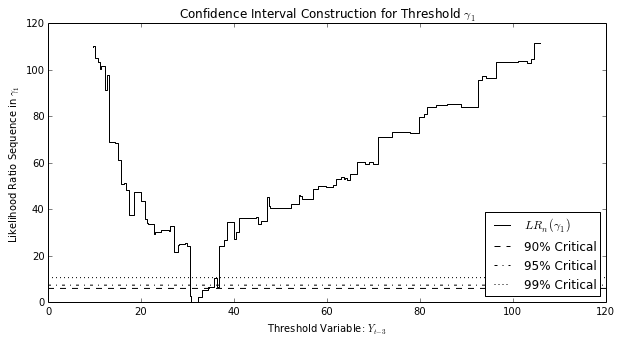

In [12]:
setar_mod23.plot_threshold_ci(0, figwidth=10, figheight=5);

As in the ARMA Notebook Example, we can take a look at in-sample dynamic prediction and out-of-sample forecasting.

In [13]:
predict_arma_mod30 = arma_mod30.predict('1990', '2012', dynamic=True)
predict_setar_mod23 = setar_mod23.predict('1990', '2012', dynamic=True)

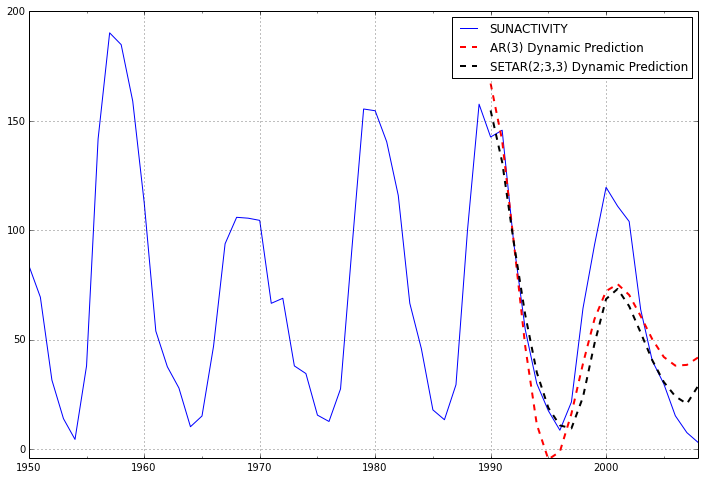

In [14]:
ax = dta.ix['1950':].plot(figsize=(12,8))
ax = predict_arma_mod30.plot(ax=ax, style='r--', linewidth=2, label='AR(3) Dynamic Prediction');
ax = predict_setar_mod23.plot(ax=ax, style='k--', linewidth=2, label='SETAR(2;3,3) Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));

It appears the dynamic prediction from the SETAR model is able to track the observed datapoints a little better than the AR(3) model. We can compare with the root mean square forecast error, and see that the SETAR does slightly better.

In [15]:
def rmsfe(y, yhat):
    return (y.sub(yhat)**2).mean()
print 'AR(3):        ', rmsfe(dta.SUNACTIVITY, predict_arma_mod30)
print 'SETAR(2;3,3): ', rmsfe(dta.SUNACTIVITY, predict_setar_mod23)

AR(3):         596.858339226
SETAR(2;3,3):  570.666050491


If we extend the forecast window, however, it is clear that the SETAR model is the only one that even begins to fit the shape of the data, because the data is cyclic.

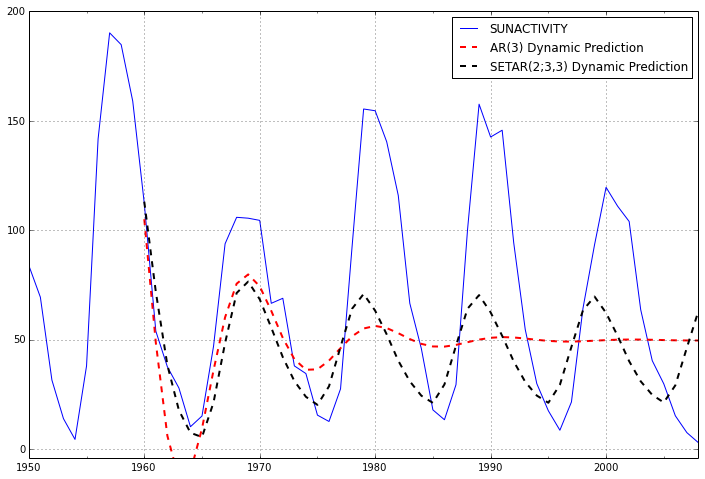

In [16]:
predict_arma_mod30_long = arma_mod30.predict('1960', '2012', dynamic=True)
predict_setar_mod23_long = setar_mod23.predict('1960', '2012', dynamic=True)
ax = dta.ix['1950':].plot(figsize=(12,8))
ax = predict_arma_mod30_long.plot(ax=ax, style='r--', linewidth=2, label='AR(3) Dynamic Prediction');
ax = predict_setar_mod23_long.plot(ax=ax, style='k--', linewidth=2, label='SETAR(2;3,3) Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));

In [17]:
print 'AR(3):        ', rmsfe(dta.SUNACTIVITY, predict_arma_mod30_long)
print 'SETAR(2;3,3): ', rmsfe(dta.SUNACTIVITY, predict_setar_mod23_long)

AR(3):         2058.19485457
SETAR(2;3,3):  1780.4834598
